# <딥러닝 8팀 Term project Final>
* # **주제: 문장 유형 분류 AI 모델 구축 - Text Sequence Classification**
* ## **Motivation**
    * 코로나 이후 전 세대에 걸쳐 대면 만남을 선호하는 비율은 감소하고, 언택트는 하나의 생활 문화로 자리 잡음.
    * 온갖 서비스를 경험하는 과정에서 우리는 하루에도 셀 수 없을 만큼 무수한 문장들을 새로이 접하고 있음.
    * **수많은 글들을 AI 모델을 활용해 학습하고, 빠르게 분류**할 수 있다면, 우리는 **더 정교하게 분류된 정보를 얻고** 이를 통해 언어가 쓰이는 모든 영역에서 **보다 사용자 친화적인 서비스를 경험할 수 있을 것으로 기대함.**  

* ## **목표**
    * -> 따라서 **언어가 사용되는 모든 영역에서 폭넓게 활용될 수 있는 문장 유형 분류 AI 모델을 개발**하고자 하였고, **문장을 입력으로 받아 문장의 4가지 category인 '유형', '시제', '극성', '확실성'의 특성을 파악하고 하나의 class로 분류하는 모델**을 개발하고자 함.

# Import

In [ ]:
!pip install datasets
!pip install transformers==4.19.0
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 54.4 MB/s eta 0:00

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import multiprocessing
import datasets
import collections
import transformers
from datasets import Dataset
from tqdm.notebook import tqdm

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from transformers import (
    AutoConfig,
    AutoTokenizer,
    TrainingArguments,
    DataCollatorWithPadding,
)

import warnings

In [ ]:
warnings.filterwarnings(action='ignore')

버전확인

In [ ]:
print('Torch version : %s' %torch.__version__)
print('Numpy version : %s' %np.__version__)
print('Pandas version : %s' %pd.__version__)
print('Datasets version : %s' %datasets.__version__)
print('Transformers version : %s' %transformers.__version__)

Torch version : 2.0.1+cu118
Numpy version : 1.22.4
Pandas version : 1.5.3
Datasets version : 2.12.0
Transformers version : 4.19.0


In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda:0
Current cuda device: 0
Count of using GPUs: 1


# Fixed RandomSeed

In [ ]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    np.random.default_rng(seed)
    random.seed(seed)

In [ ]:
SEED = 1

In [ ]:
seed_everything(SEED)

## **Wandb 이용** - 하이퍼파라미터 튜닝 & 성능 분석

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb

PLM = 'klue/roberta-large'
OUTPUT_DIR = '/content/gdrive/MyDrive/Colab Notebooks/deeplearning_termproject'
NUM_PROC = 1
# TRAIN_BATCH_SIZE = 16
# NUM_EPOCH = 3
# WEIGHT_DECAY = 1e-3
WARMUP_RATIO = 0.05
# LEARNING_RATE = 2.5e-5
SAVE_STEPS = 500
MAX_LENGTH = 128
MINIMUM_SIZE = 20
MAXIMUM_SIZE = 3000
LOGGING_STEPS = 100
CPU_COUNT = multiprocessing.cpu_count() // 2

wandb.login(key='b08c25f5bc9be7f7ffe956af9743664940786afb')
wandb.init(
        entity="yewon-min",
        project="DL23_문장유형분류"
        )

# TRAIN_BATCH_SIZE / NUM_EPOCH /WEIGHT_DECAY / LEARNING_RATE 은 Wandb

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yewon-min. Use `wandb login --relogin` to force relogin


# **1. Dataset Load**
출처 : https://dacon.io/competitions/official/236037/data

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train = pd.read_csv("/content/gdrive/MyDrive/딥러닝/팀플/train.csv")
test = pd.read_csv("/content/gdrive/MyDrive/딥러닝/팀플/test.csv")

# **1-1. EDA & Preprocessing**

### **Train dataset**
- 각 Column 별 의미


```
    * ID    : 샘플 문장 별 고유 ID
    * 문장  : 샘플 별 한개의 문장
    * 유형  : 문장의 유형 (사실형, 추론형, 대화형, 예측형)
    * 극성  : 문장의 극성 (긍정, 부정, 미정)
    * 시제  : 문장의 시제 (과거, 현재, 미래)
    * 확실성: 문장의 확실성 (확실, 불확실)
    * label : 문장 별 유형, 극성, 시제, 확실성에 대한 Class (총 72개 종류의 Class 존재)
          ex) 사실형-긍정-현재-확실
```

In [ ]:
train.describe()

,ID,문장,유형,극성,시제,확실성,label
count,16541,16541,16541,16541,16541,16541,16541
unique,16541,16506,4,3,3,2,64
top,TRAIN_00000,이들 게임은 국내 구글 플레이 매출 톱10 진입이 예상되는 기대작이다.,사실형,긍정,과거,확실,사실형-긍정-과거-확실
freq,1,2,13558,15793,8032,15192,7113


* 문장의 Count와 Unique가 다르므로 Train data에는 35쌍의 중복 문장 존재
* label을 확인하면, 4가지 카테고리 조합에서 가능한 총 72개의 label 중 64개의 label 존재

In [ ]:
df = train.drop_duplicates(subset=['문장'])

In [ ]:
df.head()

,ID,문장,유형,극성,시제,확실성,label
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실


In [ ]:
print("The number of data : %d" %len(df))

The number of data : 16506


* Train data : **중복데이터 제거**후, **총 16,506개 문장**으로 구성

### **A. 문장 내 단어(word) 및 token(음절. character) 길이 파악**

In [ ]:
word = list(train['문장'])
tokenize_sentense = [r.split()for r in word]
sentense_len_by_word = [len(t) for t in tokenize_sentense] # 띄어쓰기 기준으로 단어(word)
sentence_len_by_character = [len(s.replace(' ', '')) for s in word] # 음절(character)로 나누기

Word max length : 124
Character max length : 411


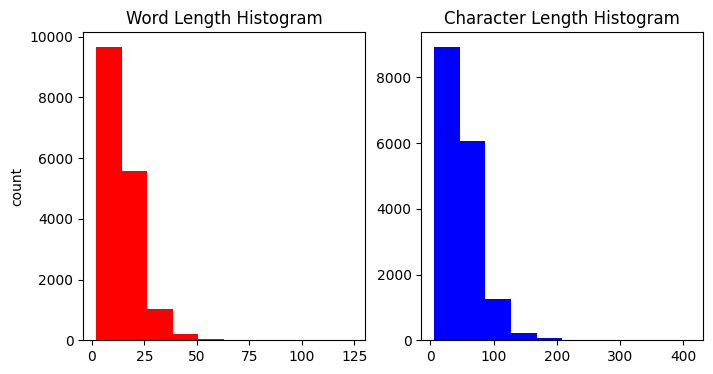

In [ ]:
plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1,2,1)
plt.title('Word Length Histogram')
plt.ylabel('count')
plt.hist(sentense_len_by_word, color= 'r')

plt.subplot(1,2,2)
plt.title('Character Length Histogram')
# plt.xlabel('characters')
# plt.ylabel('count')
plt.hist(sentence_len_by_character,color='b')

print(f"Word max length : {max(sentense_len_by_word)}")
print(f"Character max length : {max(sentence_len_by_character)}")

* 각 문장의 단어(word) 수는 대부분 50개, 음절(character) 수는 대부분 200개 이하 로 구성됨.

### **B. 4가지 category(유형, 극성, 시제, 확실성) 별 data 분포 파악**

In [ ]:
train.columns = ['ID', 'sentence', 'type', 'polarity','tense', 'certainty' , 'label']
type_dict = {"사실형" : "True", "추론형" : "Guess", "대화형" : "Talk", "예측형" : "Predict"}
polarity_dict = {"긍정" : "Pos", "부정" : "Neg" , "미정" : "No"}
tense_dict = {"과거" : "Past", "현재" : "Present", "미래" : "Future"}
certainty_dict = {"확실" : "Certainty", "불확실" : "Uncertainty"}

train['type'] = train['type'].apply(lambda x : type_dict[x])
train['polarity'] = train['polarity'].apply(lambda x : polarity_dict[x])
train['tense'] = train['tense'].apply(lambda x : tense_dict[x])
train['certainty'] = train['certainty'].apply(lambda x : certainty_dict[x])

def make_label(type,polarity,tense,certainty):
    return f"{type}-{polarity}-{tense}-{certainty}"

train['label_eng'] = train.apply(lambda x : make_label(x['type'],x['polarity'],x['tense'],x['certainty']), axis =1 , result_type = 'expand')

Text(0.5, 1.0, 'Distribution of certainty')

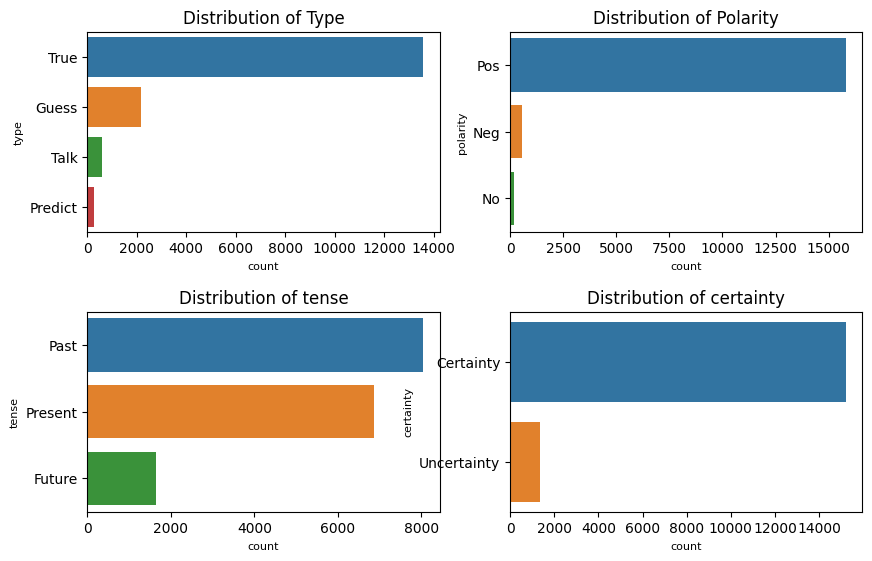

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.4)

g = sns.countplot(y="type", data=train,order = train['type'].value_counts().index , ax = axes[0][0])
axes[0][0].set_xlabel(g.get_xlabel(), fontsize=8)
axes[0][0].set_ylabel(g.get_ylabel(), fontsize=8)
axes[0][0].set_title('Distribution of Type')

g = sns.countplot(y="polarity", data=train,order = train['polarity'].value_counts().index , ax = axes[0][1])
axes[0][1].set_xlabel(g.get_xlabel(), fontsize=8)
axes[0][1].set_ylabel(g.get_ylabel(), fontsize=8)
axes[0][1].set_title('Distribution of Polarity')

g = sns.countplot(y="tense", data=train,order = train['tense'].value_counts().index , ax = axes[1][0])
axes[1][0].set_xlabel(g.get_xlabel(), fontsize=8)
axes[1][0].set_ylabel(g.get_ylabel(), fontsize=8)
axes[1][0].set_title('Distribution of tense')

g = sns.countplot(y="certainty", data=train,order = train['certainty'].value_counts().index , ax = axes[1][1])
axes[1][1].set_xlabel(g.get_xlabel(), fontsize=8)
axes[1][1].set_ylabel(g.get_ylabel(), fontsize=8)
axes[1][1].set_title('Distribution of certainty')

* 각 label 별 분포 그래프를 보아, 4개의 카테고리 모두 **전체적으로 데이터 불균형이 굉장히 심하다**는 것을 파악할 수 있었음.

### **C. 총 72가지 class(정답 label) 별 분포 파악**

In [ ]:
train['label_eng'].value_counts()

True-Pos-Past-Certainty            7113
True-Pos-Present-Certainty         4743
Guess-Pos-Present-Certainty        1101
True-Pos-Future-Certainty           649
Guess-Pos-Past-Certainty            335
                                   ... 
Talk-No-Past-Certainty                1
Predict-No-Present-Certainty          1
Predict-Neg-Present-Uncertainty       1
Predict-Neg-Past-Certainty            1
Predict-No-Past-Certainty             1
Name: label_eng, Length: 64, dtype: int64

* 총 가능한 72개의 class 중, train dataset에는 64개의 class만 존재하는 것을 확인

<Axes: xlabel='count', ylabel='label_eng'>

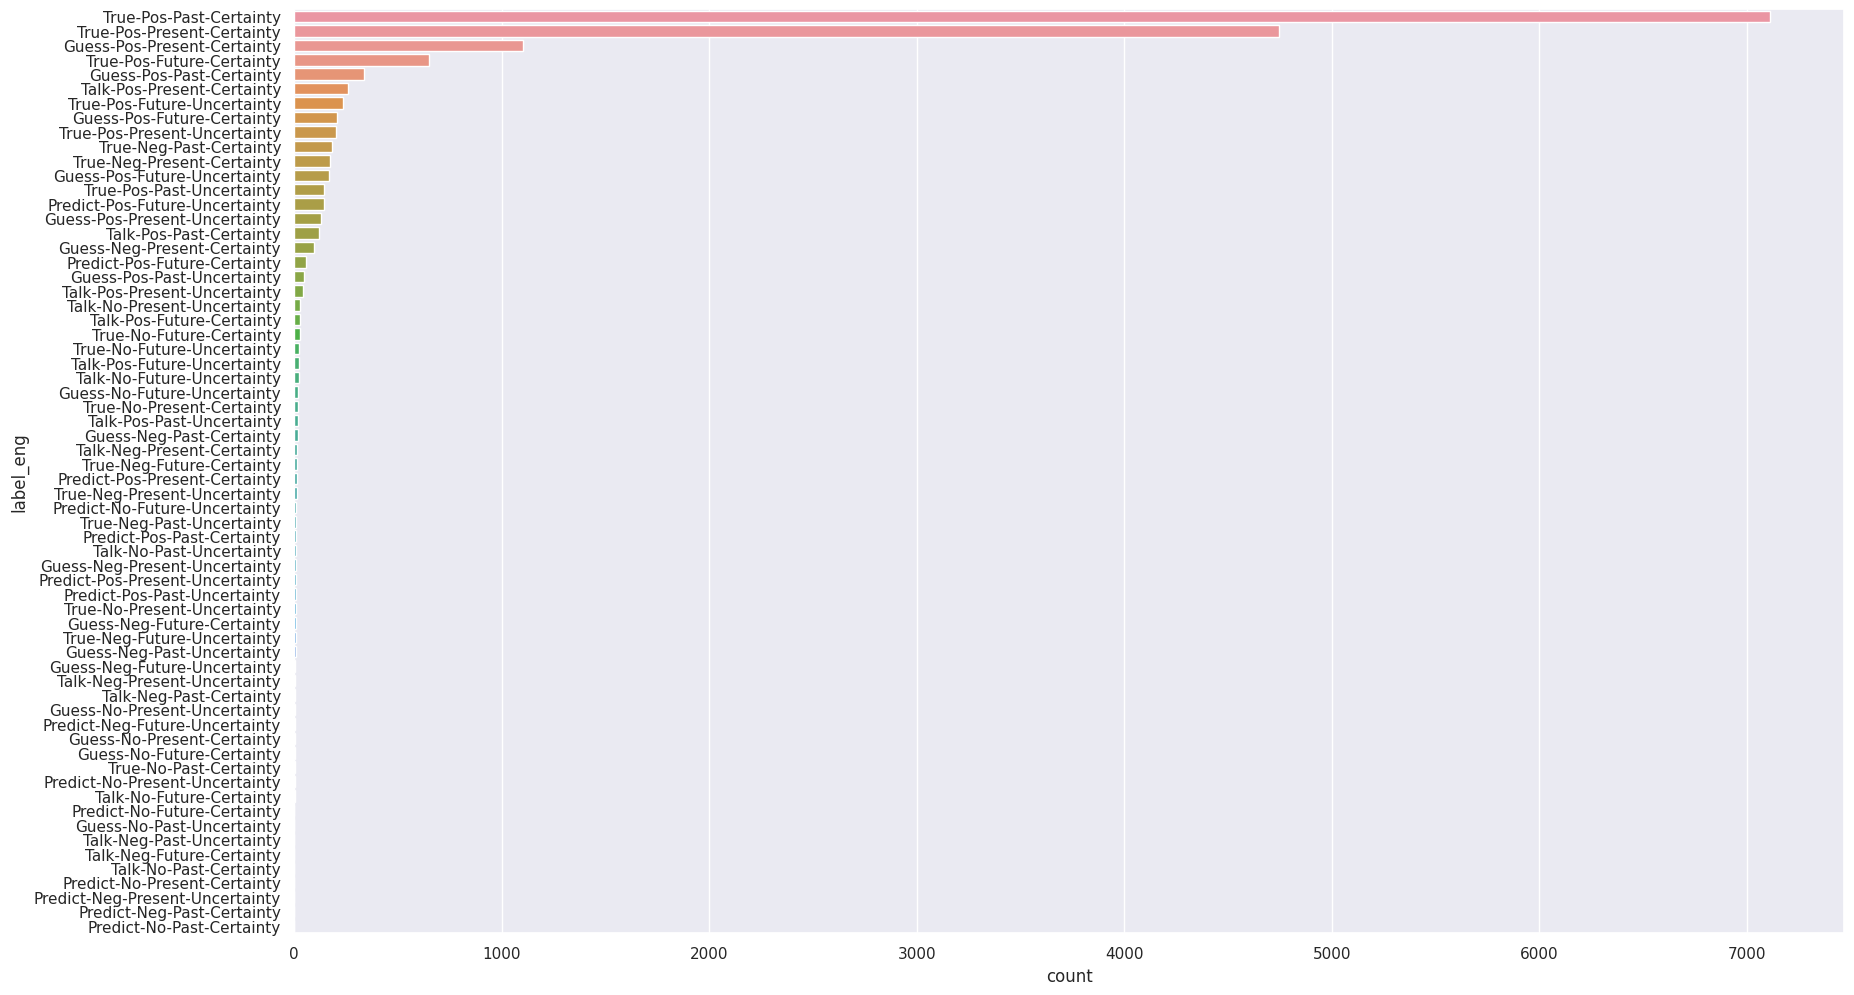

In [ ]:
sns.set(rc = {'figure.figsize':(20,12)})
sns.countplot(y="label_eng", data=train,order = train['label_eng'].value_counts().index)

* 결론적으로, **데이터 불균형이 굉장히 심한 것**을 파악

In [ ]:
for i in range(30,len(list(train['sentence']))):
    print(list(train['sentence'])[i])
    if i == 40:
        break

특히 아마타후불화는 더욱 돋보인다.
특별히 퇴계 이황, 회재 이언적, 한강 정구, 일두 정여창을 배출했던 경상도가 차별받았다고 《택리지》는 주장한다.
팔각정은 관광도로로 유명한 ＇북악 스카이웨이＇로 인근에 있어 이륜차 운전자들이 즐겨 찾는 장소로 꼽힌다.
상업영화 데뷔작 ＇플란다스의 개＇(2000)로는 흥행하지 못했지만 거물 제작자 차승재에게 강한 인상을 남기는 데 성공했다.
이번 폐간에는 유튜브, 페이스북 등 모바일 디지털 플랫폼의 부상이 크게 작용했다.
영화는 중국 선양에서 일명 ＇야차＇가 이끄는 국정원 비밀공작 전담 블랙팀과 각국 정보부 요원들의 접전을 그린 첩보 액션물이다.
문체부 측은 사교육업체 강사를 홍보 영상에 출연시킨 이유에 대해 ＂기자단 선발 일을 함께 하는 업체에서 주예지 강사가 유튜브에서 많은 조회 수를 기록한 인물이라고 추천해 홍보영상을 찍게 됐다＂고 설명했다.
국방과학연구소와 함께 한화시스템이 국내기술로 개발해 시제1호기에 탑재된 차세대 전투기의 눈으로 불리는 AESA 레이더는 2015년 미국이 AESA 기술이전을 거부한 이후 우리 정부와 방위산업체가 국내 개발을 추진해 보기 좋게 국산화를 이룬 KF-21의 핵심장비이다.
단일 단지로는 역대 최대 규모다.
사람 친구는 어느 한쪽에 애인이 생기면 끊어주는 게 쌈빡한 예의 아닐까.
멘디니는 프랭크 게리(1928~)와 동대문 디자인플라자(DDP)를 설계한 자하 하디드(1950~2016)가 명성을 날리기 전에 커버 인물로 소개했다.


* 문장을 찾아본 결과 각 문장은 뉴스 기사의 일부임을 알 수 있음.

In [ ]:
label_names = list(df['label'].unique())
label_dict = {l:i for i, l in enumerate(label_names)}

# **Formatting dataset**

In [ ]:
dataset = Dataset.from_pandas(df)
print(dataset)

Dataset({
    features: ['ID', '문장', '유형', '극성', '시제', '확실성', 'label', '__index_level_0__'],
    num_rows: 16506
})


# **1-2. Encoding dataset**

In [ ]:
model_name = PLM
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [ ]:
class Encoder :

    def __init__(self, tokenizer, max_input_length, label_dict=None, train_flag=True) :
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.label_dict = label_dict
        self.train_flag = train_flag

    def __call__(self, examples) :

        # 입력 문장 tokenizer를 통해서 인코딩
        inputs = examples['문장']
        model_inputs = self.tokenizer(inputs,
            max_length=self.max_input_length,
            return_token_type_ids=False,
            truncation=True,
        )

        # 학습을 위한 인코더인 경우 label을 인덱스로 인코딩
        if self.train_flag :
            model_inputs['labels'] = [self.label_dict[l] for l in examples['label']]

        return model_inputs

In [ ]:
encoder = Encoder(tokenizer, MAX_LENGTH, label_dict)

In [ ]:
dataset = dataset.map(encoder, batched=True, num_proc=CPU_COUNT)

Map:   0%|          | 0/16506 [00:00<?, ? examples/s]

# **1-3. Encoded dataset**

In [ ]:
dataset

Dataset({
    features: ['ID', '문장', '유형', '극성', '시제', '확실성', 'label', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 16506
})

In [ ]:
dataset = dataset.remove_columns(['ID', '문장', '유형', '극성', '시제', '확실성', 'label', '__index_level_0__'])

In [ ]:
dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 16506
})

# **2. Base Modeling**
- Stratified Sampling 적용 o
- Data Augmentation 적용 x
- Undersampling 적용 x

## Stratified Sampling

In [ ]:
from torch.utils.data.sampler import Sampler
from typing import Iterator, Optional, Sized


class StratifiedSampler(Sampler[int]):

    data_source: Sized
    replacement: bool

    def __init__(
        self,
        data_source: Sized,
        batch_size: Optional[int] = None,
        num_samples: Optional[int] = None,
        generator=None
    ) -> None:

        self.data_source = data_source
        self.batch_size = batch_size
        self._num_samples = num_samples
        self.generator = generator

        if not isinstance(self.batch_size, int) or self.batch_size <= 0:
            raise ValueError("batch_size should be a positive integer "
                             "value, but got batch_size={}".format(self.batch_size))

        if not isinstance(self.num_samples, int) or self.num_samples <= 0:
            raise ValueError("num_samples should be a positive integer "
                             "value, but got num_samples={}".format(self.num_samples))

    @property
    def num_samples(self) -> int:
        # dataset size might change at runtime
        if self._num_samples is None:
            return len(self.data_source)
        return self._num_samples

    def get_label_indices(self, labels) :
        label_indices = collections.defaultdict(list)

        total_size = len(labels)
        for i in range(total_size) :
            label = labels[i]
            label_indices[label].append(i)

        for l in label_indices :
            random.shuffle(label_indices[l])

        return label_indices

    def __iter__(self) -> Iterator[int]:
        n = len(self.data_source)
        if self.generator is None:
            seed = int(torch.empty((), dtype=torch.int64).random_().item())
            generator = torch.Generator()
            generator.manual_seed(seed)
        else:
            generator = self.generator

        # 각 label별로 데이터 인덱스들을 정리
        total_size = len(self.data_source['labels'])
        labels = self.data_source['labels']
        label_indices = self.get_label_indices(labels)

        # 각 label이 가지는 데이터 수를 파악
        label_batch_sizes = {}
        for l in label_indices :
            l_indices = label_indices[l]
            label_batch_sizes[l] = len(l_indices)

        # 데이터 수를 많이 가지고 있는 label들을 파악
        label_items = sorted(label_batch_sizes.items(), key=lambda x : x[1], reverse=True)
        iter_size = total_size // self.batch_size

        # Label 1 : 사실형-긍정-과거-확실
        item1 = label_items[0][0]
        item1_size = len(label_indices[item1])
        item1_batch_size = item1_size // iter_size
        item1_indices = label_indices[item1]

        # Label 2 : 사실형-긍정-미래-확실
        item2 = label_items[1][0]
        item2_size = len(label_indices[item2])
        item2_batch_size = item2_size // iter_size
        item2_indices = label_indices[item2]

        # Label 1, 2 제외한 나머지 label들
        item3_size = total_size - (item1_size + item2_size)
        item3_batch_size = item3_size // iter_size
        item3_indices = []
        for l in label_indices :
            if l != item1 and l != item2 :
                item3_indices.extend(label_indices[l])
        random.shuffle(item3_indices)

        # 3개의 그룹으로 나뉘어진 인덱스들을 각 비율에 맞게 batch에 들어가게끔 한다.
        """
        예시
        train batch size : 16

            1) Label 1 (사실형-긍정-미래-확실) : 4
            2) Label 2 (사실형-긍정-과거-확실) : 6
            3) 그 외 나머지 : 5

        하나의 batch안에 모두 같은 label이 되는 것을 방지한다.
        """
        sampled = []
        for i in range(iter_size) :
            sub_sampled = []

            indices = item1_indices[i*item1_batch_size:(i+1)*item1_batch_size]
            if len(indices) > 0 :
                sub_sampled.extend(indices)

            indices = item2_indices[i*item2_batch_size:(i+1)*item2_batch_size]
            if len(indices) > 0 :
                sub_sampled.extend(indices)

            indices = item3_indices[i*item3_batch_size:(i+1)*item3_batch_size]
            if len(indices) > 0 :
                sub_sampled.extend(indices)

            random.shuffle(sub_sampled)
            sampled.extend(sub_sampled)

        remain_ids = []

        remain_ids.extend(item1_indices[item1_batch_size*iter_size:])
        remain_ids.extend(item2_indices[item2_batch_size*iter_size:])
        remain_ids.extend(item3_indices[item3_batch_size*iter_size:])

        if len(remain_ids) > 0 :
            random.shuffle(remain_ids)
            sampled.extend(remain_ids)

        yield from sampled

    def __len__(self) -> int:
        return self.num_samples

In [ ]:
# Load Config & Model building
config = AutoConfig.from_pretrained(PLM)

config.num_labels = len(label_names)
config.cls_token_id = tokenizer.cls_token_id
config.eos_token_id = tokenizer.eos_token_id

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

## Modeling

In [ ]:
# from transformers.modeling_outputs import SequenceClassifierOutput
# from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel, RobertaModel

# class ClassificationHead1(nn.Module):
#     def __init__(self, hidden_size, classifier_dropout, num_labels):
#         super().__init__()
#         self.dense = nn.Linear(hidden_size, hidden_size)
#         self.dropout = nn.Dropout(classifier_dropout)
#         self.out_proj = nn.Linear(hidden_size, num_labels)

#     def forward(self, features):
#         x = self.dropout(features)
#         x = self.dense(x)
#         x = torch.tanh(x)
#         x = self.dropout(x)
#         x = self.out_proj(x)
#         return x

# class RobertaSpecialTokenForSequenceClassification1(RobertaPreTrainedModel):
#     _keys_to_ignore_on_load_missing = [r"position_ids"]

#     def __init__(self, config):
#         super().__init__(config)
#         self.config = config
#         self.num_labels = config.num_labels
#         self.roberta = RobertaModel(config, add_pooling_layer=False)

#         self.dropout = nn.Dropout(config.hidden_dropout_prob)
#         self.classifier = ClassificationHead1(config.hidden_size, config.hidden_dropout_prob, config.num_labels)

#     def forward(
#         self,
#         input_ids=None,
#         attention_mask=None,
#         token_type_ids=None,
#         position_ids=None,
#         head_mask=None,
#         inputs_embeds=None,
#         labels=None,
#         output_attentions=None,
#         output_hidden_states=None,
#         return_dict=None,
#     ):

#         return_dict = return_dict if return_dict is not None else self.config.use_return_dict

#         outputs = self.roberta(
#             input_ids,
#             attention_mask=attention_mask,
#             token_type_ids=token_type_ids,
#             position_ids=position_ids,
#             head_mask=head_mask,
#             inputs_embeds=inputs_embeds,
#             output_attentions=output_attentions,
#             output_hidden_states=output_hidden_states,
#             return_dict=return_dict,
#         )
#         sequence_output = outputs[0]

#         logits = self.classifier(sequence_output)

#         loss = None
#         if labels is not None:
#             loss_fct = nn.CrossEntropyLoss()
#             loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

#         if not return_dict:
#             output = (logits,) + outputs[2:]
#             return ((loss,) + output) if loss is not None else output

#         return SequenceClassifierOutput(
#             loss=loss,
#             logits=logits,
#             hidden_states=outputs.hidden_states,
#             attentions=outputs.attentions,
#         )

In [ ]:
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel, RobertaModel

class ClassificationHead1(nn.Module):
    def __init__(self, hidden_size, classifier_dropout, num_labels):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(hidden_size, num_labels)

    # Residual Connection과 유사한 구조
    def forward(self, features):
        x = self.dropout(features)
        x = self.dense(x)
        x = torch.tanh(x) + features
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class RobertaSpecialTokenForSequenceClassification1(RobertaPreTrainedModel):
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config, add_pooling_layer=False)

        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = ClassificationHead1(config.hidden_size*2, config.hidden_dropout_prob, config.num_labels)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = outputs[0]
        batch_size, _, _ = sequence_output.shape

        # 입력 양 끝에 cls, eos token을 concat해서 classification에 보내는 구조
        cls_flag = input_ids == self.config.cls_token_id
        eos_flag = input_ids == self.config.eos_token_id

        sequence_output = sequence_output[cls_flag + eos_flag].view(batch_size, -1)

        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
model1 = RobertaSpecialTokenForSequenceClassification1.from_pretrained(PLM, config=config)

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaSpecialTokenForSequenceClassification1: ['lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaSpecialTokenForSequenceClassification1 from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaSpecialTokenForSequenceClassification1 from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaSpecialTokenForSequenceClassification1 were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifi

In [ ]:
## Data Collator
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding=True,
    max_length=MAX_LENGTH
)

## Trainer

In [ ]:
from transformers import Trainer
from typing import Dict, List, Any, Union, Tuple, Optional
from transformers.trainer_pt_utils import nested_detach


class Trainer(Trainer) :

    def _get_train_sampler(self) -> Optional[torch.utils.data.Sampler]:

        generator = torch.Generator()
        seed = int(torch.empty((), dtype=torch.int64).random_().item())
        generator.manual_seed(seed)

        seed = self.args.data_seed if self.args.data_seed is not None else self.args.seed
        train_batch_size = self.args.per_device_train_batch_size
        return StratifiedSampler(self.train_dataset, batch_size=train_batch_size, generator=generator)


    # KL-Divergence Loss 계산하는 코드
    def get_kl_loss(self, loss_fn, logits_1, logits_2, alpha=1) :
        loss_kl_1 = loss_fn(F.log_softmax(logits_1, dim=-1), F.softmax(logits_2, dim=-1))
        loss_kl_2 = loss_fn(F.log_softmax(logits_2, dim=-1), F.softmax(logits_1, dim=-1))
        return alpha * (loss_kl_1 + loss_kl_2) / 2


    # 최적화 부분 : R-Drop을 이용해서 Loss를 계산한다. (Train 할 때만)
    def compute_loss(self, model, inputs):
        num_labels = model.config.num_labels

        input_names = inputs.keys()
        batch_size = inputs['input_ids'].shape[0]
        labels = inputs.pop('labels')

        # 같은 입력을 2개 concat한다.
        for input_name in input_names :
            batch = inputs[input_name]
            inputs[input_name] = torch.cat([batch, batch], dim=0)

        # 출력을 구한다.
        outputs = model(**inputs)

        # 앞서 concat 한 부분을 나눈다.
        batch_logits_1 = outputs.logits[:batch_size, :]
        batch_logits_2 = outputs.logits[batch_size:, :]

        # 각 부분에 대해서 cross entropy loss의 평균을 구한다.
        loss_fct_1 = nn.CrossEntropyLoss()
        loss_nll = (
            loss_fct_1(batch_logits_1.view(-1, num_labels), labels.view(-1)) + \
            loss_fct_1(batch_logits_2.view(-1, num_labels), labels.view(-1))
        )

        # 두 부분의 logit 분포 차이가 적어질 수 있게 KL-Divergence Loss 구한다.
        loss_fct_2 = nn.KLDivLoss(reduction='batchmean')
        loss_kl = self.get_kl_loss(loss_fct_2, batch_logits_1, batch_logits_2)

        loss = loss_nll + loss_kl
        return loss


    # Validation 할 때 Loss를 구하기 위한 코드
    def compute_eval_loss(self, model, inputs, return_outputs=False):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        # Save past state if it exists
        # TODO: this needs to be fixed and made cleaner later.
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            # We don't use .loss here since the model may return tuples instead of ModelOutput.
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
        return (loss, outputs) if return_outputs else loss


    # Huggingface Validation & Prediction Code
    def prediction_step(
        self,
        model: nn.Module,
        inputs: Dict[str, Union[torch.Tensor, Any]],
        prediction_loss_only: bool,
        ignore_keys: Optional[List[str]] = None,
    ) -> Tuple[Optional[torch.Tensor], Optional[torch.Tensor], Optional[torch.Tensor]]:

        has_labels = all(inputs.get(k) is not None for k in self.label_names)
        inputs = self._prepare_inputs(inputs)
        if ignore_keys is None:
            if hasattr(self.model, "config"):
                ignore_keys = getattr(self.model.config, "keys_to_ignore_at_inference", [])
            else:
                ignore_keys = []

        # labels may be popped when computing the loss (label smoothing for instance) so we grab them first.
        if has_labels:
            labels = nested_detach(tuple(inputs.get(name) for name in self.label_names))
            if len(labels) == 1:
                labels = labels[0]
        else:
            labels = None

        with torch.no_grad():
            if has_labels:
                with self.autocast_smart_context_manager():
                    loss, outputs = self.compute_eval_loss(model, inputs, return_outputs=True)
                loss = loss.mean().detach()

                if isinstance(outputs, dict):
                    logits = tuple(v for k, v in outputs.items() if k not in ignore_keys + ["loss"])
                else:
                    logits = outputs[1:]
            else:
                loss = None
                with self.autocast_smart_context_manager():
                    outputs = model(**inputs)
                if isinstance(outputs, dict):
                    logits = tuple(v for k, v in outputs.items() if k not in ignore_keys)
                else:
                    logits = outputs
                # TODO: this needs to be fixed and made cleaner later.
                if self.args.past_index >= 0:
                    self._past = outputs[self.args.past_index - 1]

        if prediction_loss_only:
            return (loss, None, None)

        logits = nested_detach(logits)
        if len(logits) == 1:
            logits = logits[0]

        return (loss, logits, labels)

## Training

In [ ]:
import re
import numpy as np
from datasets import load_metric
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from transformers import EvalPrediction

class Metrics :

    def __init__(self, label_names, label_dict) :
        self.label_names = label_names
        self.label_dict = label_dict
        self.decoder = {i : l for l, i in label_dict.items()}
        self.tags = ['type', 'polarity', 'time', 'certainty']

    def compute_metrics(self, pred: EvalPrediction):
        labels = pred.label_ids
        predictions = pred.predictions

        metric = {}

        eval_size = len(labels)
        pred_args = predictions.argmax(-1)

        # 각 Label과 Prediction을 문자열로 변환
        labels_string = [self.decoder[l] for l in labels]
        predictions_string = [self.decoder[p] for p in pred_args]

        # 유형별로 정리, Accuracy 계산
        type_labels = [l.split('-')[0] for l in labels_string]
        type_preds = [p.split('-')[0] for p in predictions_string]
        type_acc = accuracy_score(type_labels, type_preds)
        metric['type-acc'] = type_acc

        # 극성별로 정리, Accuracy 계산
        polarity_labels = [l.split('-')[1] for l in labels_string]
        polarity_preds = [p.split('-')[1] for p in predictions_string]
        polarity_acc = accuracy_score(polarity_labels, polarity_preds)
        metric['polarity-acc'] = polarity_acc

        # 시제별로 정리, Accuracy 계산
        time_labels = [l.split('-')[2] for l in labels_string]
        time_preds = [p.split('-')[2] for p in predictions_string]
        time_acc = accuracy_score(time_labels, time_preds)
        metric['time-acc'] = time_acc

        # 확실성별로 정리, Accuracy 계산
        certainty_labels = [l.split('-')[3] for l in labels_string]
        certainty_preds = [p.split('-')[3] for p in predictions_string]
        certainty_acc = accuracy_score(certainty_labels, certainty_preds)
        metric['certainty-acc'] = certainty_acc

        # 전체적인 F1 Score 계산
        decoded_pred_vectors = []
        decoded_label_vectors = []
        for p, l  in zip(pred_args, labels) :
            pred_vector = [0] * len(self.label_names)
            pred_vector[p] = 1

            label_vector = [0] * len(self.label_names)
            label_vector[l] = 1

            decoded_pred_vectors.append(pred_vector)
            decoded_label_vectors.append(label_vector)

        # 구체적인 분석을 recall, precision을 같이 계산
        f1 = f1_score(decoded_label_vectors, decoded_pred_vectors, average='weighted')
        recall = recall_score(decoded_label_vectors, decoded_pred_vectors, average='weighted')
        precision = precision_score(decoded_label_vectors, decoded_pred_vectors, average='weighted')

        metric['f1'] = f1
        metric['recall'] = recall
        metric['precision'] = precision

        return metric['f1']

compute_metrics = Metrics(label_names, label_dict)

In [ ]:
sweep_configuration = {
    'method': 'random',
    'name': 'sweep',
    'metric': {'goal': 'maximize', 'name': 'eval/f1'},
    'parameters':
    {
        'batch_size': {'values': [10, 16, 25]},
        'epochs': {'values': [3, 5, 7]},
        'learning_rate': {
            'distribution': 'log_uniform_values',
            'min': 2.5e-5,
            'max': 1e-3
        },
        'weight_decay': {
            'distribution': 'q_uniform',
            'min': 0,
            'max': 1e-2,
            'q': 0.001
        },
     }
}

# Initialize sweep by passing in config.

sweep_id = wandb.sweep(
  sweep=sweep_configuration,
  project="DL23_문장유형분류"
  )

Create sweep with ID: ieiev422
Sweep URL: https://wandb.ai/dl23_termproject/DL23_%EB%AC%B8%EC%9E%A5%EC%9C%A0%ED%98%95%EB%B6%84%EB%A5%98/sweeps/ieiev422


In [ ]:
sweep_id = wandb.sweep(sweep_configuration, project='DL23_문장유형분류')

Create sweep with ID: cla7au2j
Sweep URL: https://wandb.ai/dl23_termproject/DL23_%EB%AC%B8%EC%9E%A5%EC%9C%A0%ED%98%95%EB%B6%84%EB%A5%98/sweeps/cla7au2j


In [ ]:
def train1(config=None):
    wandb.init(config=config)
    config = wandb.config

    training_args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, 'model_1'),     # output directory
    num_train_epochs=config.epochs,                                 # total number of training epochs
    learning_rate=config.learning_rate,                                # learning_rate
    per_device_train_batch_size=config.batch_size,               # batch size per device during training
    warmup_ratio=WARMUP_RATIO,                                  # number of warmup steps for learning rate scheduler
    weight_decay=config.weight_decay,                                  # strength of weight decay
    logging_steps=LOGGING_STEPS,                                # log saving step.
    evaluation_strategy='no',                                   # evaluation strategy to adopt during training
    save_strategy='steps',                                      # save strategy to adopt during training
    save_steps=SAVE_STEPS,                                      # evaluation step.
    dataloader_num_workers=CPU_COUNT,                           # the number of workers
    report_to='wandb',
    metric_for_best_model="f1",
)

    trainer = Trainer(
    model1,
    args = training_args,
    train_dataset=dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    #num_workers=2

)
    trainer.train()
    #wandb.finish
    wandb.finish()

In [ ]:
# wandb.agent(sweep_id, train1, count=1)

# **Basemodel wandb 학습과정**

<img src='https://drive.google.com/uc?export=download&id=1Y8o_L5DQ7Z3JjnBL1kJc2mob5SrnA2fA'>

<img src='https://drive.google.com/uc?export=download&id=1sE4D3wPHwoRbgM6X4BjxmAnTXjftYyA1'>

<img src='https://drive.google.com/uc?export=download&id=1KtBBIeANAA9xUlJl3wjYUMnSjylJY2eX'>

<img src='https://drive.google.com/uc?export=download&id=1aleKxifXMIcGxNRhC1zt7cuy19Ih-0qO'>



* 학습 epoch이 진행될수록 learning_rate 및 loss가 잘 감소되고 있는 것을 확인.

# **Basemodel Inference** - **Weighted F1 score** Evaluation

In [ ]:
base_submission_df = pd.read_csv('/content/gdrive/MyDrive/딥러닝/팀플/sample_submission.csv')
base_test_label_df = pd.read_csv("/content/gdrive/MyDrive/딥러닝/팀플/test.csv")
base_merged_df = base_test_label_df.merge(base_submission_df, on = 'ID')

test_label_names = list(base_merged_df['label'].unique())
test_label_dict = {l:i for i, l in enumerate(test_label_names)}
test_dataset = Dataset.from_pandas(base_merged_df)

test_encoder = Encoder(tokenizer, MAX_LENGTH, test_label_dict)
test_dataset = test_dataset.map(test_encoder, batched=True, num_proc=CPU_COUNT)

#Final_model = RobertaSpecialTokenForSequenceClassification1.from_pretrained('/content/gdrive/MyDrive/Colab Notebooks/deeplearning_termproject/model_1/checkpoint-3500/', config=config, state_dict=torch.load('/content/gdrive/MyDrive/Colab Notebooks/deeplearning_termproject/model_1/checkpoint-3500/pytorch_model.bin'))
Final_model = RobertaSpecialTokenForSequenceClassification1.from_pretrained('/content/gdrive/MyDrive/Colab Notebooks/deeplearning_termproject/model_1/checkpoint-10500', config=config, state_dict=torch.load('/content/gdrive/MyDrive/Colab Notebooks/deeplearning_termproject/model_1/checkpoint-10500/pytorch_model.bin'))

Map:   0%|          | 0/7090 [00:00<?, ? examples/s]

In [ ]:
test_dataset = test_dataset.remove_columns(['ID', '문장', 'label', '__index_level_0__'])

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True, max_length=MAX_LENGTH)

def predict_labels(model, dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, collate_fn=data_collator)
    all_predictions = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.cpu().numpy().tolist())

    return all_predictions

In [ ]:
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
base_merged_df['label'] = label_encoder.fit_transform(base_merged_df['label'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Final_model.to(device)

predictions = predict_labels(Final_model, test_dataset)
true_labels = base_merged_df['label'].tolist()
f1_score = sklearn.metrics.f1_score(true_labels, predictions, average='weighted')
print('F1 score:', f1_score)

F1 score: 0.4647033347769597


* ### **base model에 대한 최종 weighted F1 score : 0.46**

# **3. 성능 향상을 위한 Method**
* 4가지 category(유형, 극성, 시제, 확실성) data의 Class Imbalance가 매우 심함 -> 오버피팅 문제 등 모델의 성능에 치명적인 문제를 야기시킬 수 있음.
* 따라서 학습에 1) Data Augmentation 2) Undersampling 3) stratified sampling 기법 진행

# **3-1. Augmentation**
* 데이터셋의 불균형이 매우 심하므로, 모델 성능 향상 시도를 위해 data augmentation 시행.


* **증강 방법**
    * **1) 구두점 삽입을 통한 문장 변형**

        * before : '단 어떤 영웅도 2주 연속 제외되지 않으며 영웅 로테이션은 팬, 선수 등의 의견을 적극 수렴해 시즌 중에도 수정될 수 있다.'
            
        * after : '단**,** 어떤 영웅도 2주 연속 제외되지 않으며 영웅 로테**:**이션은 팬, 선수 등의 의견을 적극 수렴해 시즌 중에도 수정될 수 있다.'

    * **2) 문장 내의 몇몇 단어들을 임의의 단어로 변환**

        * before : '확실히 백내장 진단을 받았어도 입원 치료를 받을 만큼 특별한 상황이었음을 입증하지 못하면 30만원 이상의 보험금을 받기 어려울 전망이다.'
        
        * after : '확실히 백 된장 진단을 받았어도 입원 치료를 받을 만큼 특별한 **보잘것없이 운전음**을 입증하지 못하면 30**으리원 원단**의 보험금을 받 **고등학생** 어려울 전망이다.'

    * **3) 문장의 순서 역전**

        * before : '**그렇다면 차천로는 과연 어떤** 비석을 두고 이런 말을 했던 걸까.'

        * after : '비석을 두고 이런 말을 했던 걸까. **그렇다면 차천로는 과연 어떤**'
    
    * **4) 문장 내 임의 단어 삭제**
        
        * before : '이것이 만약 상업적인 의도였다면 이렇게까지 하지 못했을 것이다.'

        * after : '이것이 만약 상업적인 의도였다면 이렇게까지 하지 것이다.'



# **3-2. Undersampoling**
* 각 Lable 별로 데이터 수를 판단
    
    1. 데이터 수가 **minimum_size(20개) 이하이면 앞선 방법으로 데이터 증강**
    2. 데이터 수가 **maximum_size(3000개) 이상이면 데이터의 80%만을 임의로 선정해서 모델을 학습**.

In [ ]:
class Augmentation :

    def __init__(self, tokenizer, max_num, min_num, reduction=0.8, undersampling_ratio=0.8, eval_flag=True) :
        self.tokenizer = tokenizer
        self.max_num = max_num
        self.min_num = min_num
        self.reduction = reduction
        self.undersampling_ratio = undersampling_ratio
        self.punct = [".", ";", "?", ":", "!", ","]
        self.eval_flag = eval_flag

    def __call__(self, dataset):

        labels = dataset['label']

        # 각 Label별로 Index들을 정리한다.
        label_ids = collections.defaultdict(list)
        for i, l in enumerate(labels) :
            label_ids[l].append(i)

        # 각 Label 별로 데이터 크기에 따라서 undersampling, data augmentation을 따로 진행한다.
        total_id_list = []
        for l in label_ids :
            id_list = label_ids[l]
            previous_size = len(id_list) # 기존 데이터 갯수

            # 최소 갯수 보다 많으면 데이터 증강을 하지 않음 (20개)
            if previous_size > self.min_num :
                if self.eval_flag :
                    # validation을 할 때는 이미 Validation을 할 때 20%를 각 Label에서 가져가끼 때문에 그대로
                    augmentated_id_list = id_list
                else :
                    # traina만 할 때는 validation과 같은 환경을 맞추기 위해서 각 전체 데이터 수의 80%만을 선정
                    ## 전체 데이터를 다 쓰는 것보다 특정 비율을 가지고 임의로 선택하고 모델들을 앙상블 했을 때 더 좋은 효과를 가질 것이라고 판단
                    sample_size = int(len(id_list) * self.reduction)
                    augmentated_id_list = random.sample(id_list, sample_size)

                # 최대 갯수보다 많으면 (3000개)
                if len(augmentated_id_list) > self.max_num :
                    # 데이터 수의 80%를 임의 선택
                    augmentated_id_list = random.sample(
                        augmentated_id_list,
                        int(len(augmentated_id_list) * self.undersampling_ratio)
                    )

                # (index, status) 구조로 저장
                # status 0 : 데이터 변형 대상 아님, status : 1 데이터 변형 대상
                augmentated_id_list = [(a_id, 0) for a_id in augmentated_id_list]

            # 최소 갯수 보다 많으면 데이터 증강을 진행 (20개)
            else :
                # 기존 데이터
                augmentated_id_list = [(a_id, 0) for a_id in id_list]
                # 기존 데이터를 복사 (20개가 넘을 떼 까지)
                while len(id_list) < self.min_num :
                    id_list = id_list * 2

                # 기존 데이터 + 복사된 변형 될 데이터 해서 20개를 맞춘다.
                augmentated_id_list = augmentated_id_list + \
                    [(a_id, 1) for a_id in random.sample(id_list, self.min_num - previous_size)]

            print('Category : %s \t Previous size : %d, Current size : %d' %(l, previous_size, len(augmentated_id_list)))

            total_id_list.extend(augmentated_id_list)

        org_size, add_size = 0, 0
        for _, status in total_id_list :
            if status == 0 :
                org_size += 1
            else :
                add_size += 1
        print('Original data size : %d \t Augment data size : %d' %(org_size, add_size))

        # 데이터 셔플
        random.shuffle(total_id_list)

        # huggingface를 사용하기 때문에 datasets class 형식으로 맞춤
        total_dataset = []
        for i, status in tqdm(total_id_list) :
            data = self.augment(dataset[i], status)
            total_dataset.append(data)

        df = pd.DataFrame(total_dataset)
        dataset = Dataset.from_pandas(df)
        return dataset


    # 1) 구두점 삽입을 통한 문장 변형
    def aeda(self, data) :
        sentence = data['문장']
        # 구두점 삽입 횟수
        insert_size = np.random.randint(1, len(sentence) // 5)

        chars = list(sentence)
        while insert_size > 0 :
            # 구두점 선택
            punct_id = np.random.randint(len(self.punct))
            punct = self.punct[punct_id]

            # 구두점 삽입 위치 선정
            insert_id = np.random.randint(len(chars))
            # 구두점 삽입
            chars = chars[:insert_id] + [punct] + chars[insert_id:]

            insert_size -= 1

        sentence = ''.join(chars)
        data['문장'] = sentence
        return data


    # 2) 문장 내의 몇몇 단어들을 임의의 단어로 변환
    def change(self, data) :
        sentence = data['문장']
        # tokenizer를 통해서 index들로 변환
        tokens = self.tokenizer.encode(sentence)[1:-1]

        # 바꾸는 단어 수 선택 (문장의 길이에 따라서 달라진다.)
        change_size = int(len(tokens) * 0.15)

        if change_size > 0 :
            change_ids = random.sample(range(len(tokens)), change_size)
            for c_id in change_ids :
                tokens[c_id] = np.random.randint(len(self.tokenizer))

            data['문장'] = self.tokenizer.decode(tokens)
        return data


    # 3) 문장의 순서 역전
    def reverse(self, data) :
        sentence = data['문장']
        words = sentence.split(' ')

        if len(words) > 5 :
            index = np.random.randint(1, len(words) - 1)
            reversed = words[index:] + words[:index]
            sentence = ' '.join(reversed)

        data['문장'] = sentence
        return data


    # 4) 문장 내 임의 단어 삭제
    def delete(self, data) :

        sentence = data['문장']
        words = sentence.split(' ')

        if len(words) > 5 :
            word_size = len(words)
            # 삭제 단어 횟수 선정 (문장의 길이에 따라서 정해진다.)
            del_size = int(word_size * 0.2)
            # 삭제 단어 위치 선정
            del_indices = random.sample(range(word_size), del_size)

            deleted = []
            for i, word in enumerate(words) :
                if i in del_indices :
                    continue
                deleted.append(word)

            sentence = ' '.join(deleted)

        data['문장'] = sentence
        return data


    def augment(self, data, status) :
        if status == 0 :
            return data
        else :
            option = np.random.randint(4)
            if option == 0 :
                data = self.aeda(data)
            elif option == 1 :
                data = self.reverse(data)
            elif option == 2 :
                data = self.delete(data)
            else :
                data = self.change(data)

            return data

### Data augmentation 및 Undersampling 적용

In [ ]:
augmentator = Augmentation(
    tokenizer=tokenizer,
    max_num=MAXIMUM_SIZE,
    min_num=MINIMUM_SIZE,
    eval_flag=False
)

In [ ]:
# dataset loading
train = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/deeplearning_termproject/open/train.csv")

df = train.drop_duplicates(subset=['문장'])
# df.head()

dataset = Dataset.from_pandas(df)
# print(dataset)

model_name = PLM
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
encoder = Encoder(tokenizer, MAX_LENGTH, label_dict)
dataset = dataset.map(encoder, batched=True, num_proc=CPU_COUNT)

augmentator = Augmentation(
    tokenizer=tokenizer,
    max_num=MAXIMUM_SIZE,
    min_num=MINIMUM_SIZE,
    eval_flag=False
)
dataset = augmentator(dataset)
dataset = dataset.remove_columns(['ID', '문장', '유형', '극성', '시제', '확실성', 'label', '__index_level_0__'])

Map:   0%|          | 0/16506 [00:00<?, ? examples/s]

Category : 사실형-긍정-현재-확실 	 Previous size : 4733, Current size : 3028
Category : 사실형-긍정-과거-확실 	 Previous size : 7098, Current size : 4542
Category : 사실형-긍정-미래-확실 	 Previous size : 648, Current size : 518
Category : 추론형-부정-현재-확실 	 Previous size : 93, Current size : 74
Category : 예측형-긍정-미래-불확실 	 Previous size : 141, Current size : 112
Category : 추론형-긍정-현재-확실 	 Previous size : 1099, Current size : 879
Category : 추론형-긍정-과거-확실 	 Previous size : 334, Current size : 267
Category : 추론형-긍정-현재-불확실 	 Previous size : 130, Current size : 104
Category : 대화형-긍정-미래-확실 	 Previous size : 26, Current size : 20
Category : 사실형-미정-현재-확실 	 Previous size : 18, Current size : 20
Category : 사실형-부정-과거-확실 	 Previous size : 183, Current size : 146
Category : 예측형-부정-과거-확실 	 Previous size : 1, Current size : 20
Category : 추론형-긍정-미래-확실 	 Previous size : 204, Current size : 163
Category : 사실형-긍정-미래-불확실 	 Previous size : 236, Current size : 188
Category : 대화형-긍정-현재-확실 	 Previous size : 255, Current size : 204
Category : 

  0%|          | 0/11858 [00:00<?, ?it/s]

In [ ]:
dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 11858
})

# **3-3) Stratified Sampling**
<Stratified Sampling Framework>
<img src="https://drive.google.com/uc?export=download&id=1fMc6LI3SF1M646EzkeyNXrQVgCvwKUon">

* 데이터 불균형이 심하기 때문에, 학습할 때 Label을 적절히 섞어서 Batch를 구성

    * Group1 : 사실형-긍정-현재-확실 : 3028개

    * Group2 : 사실형-긍정-과거-확실 : 4542개

    * Group3 : 나머지 : 4288개

* 하나의 Batch에 3개의 그룹의 데이터를 데이터 수 비율에 맞게 구성

    * Train Batch Size : 16

    * 사실형-긍정-현재-확실 : 대략 7개

    * 사실형-긍정-과거-확실 : 대략 4개

    * 나머지 : 대략 5개






In [ ]:
from torch.utils.data.sampler import Sampler
from typing import Iterator, Optional, Sized


class StratifiedSampler(Sampler[int]):

    data_source: Sized
    replacement: bool

    def __init__(
        self,
        data_source: Sized,
        batch_size: Optional[int] = None,
        num_samples: Optional[int] = None,
        generator=None
    ) -> None:

        self.data_source = data_source
        self.batch_size = batch_size
        self._num_samples = num_samples
        self.generator = generator

        if not isinstance(self.batch_size, int) or self.batch_size <= 0:
            raise ValueError("batch_size should be a positive integer "
                             "value, but got batch_size={}".format(self.batch_size))

        if not isinstance(self.num_samples, int) or self.num_samples <= 0:
            raise ValueError("num_samples should be a positive integer "
                             "value, but got num_samples={}".format(self.num_samples))

    @property
    def num_samples(self) -> int:
        # dataset size might change at runtime
        if self._num_samples is None:
            return len(self.data_source)
        return self._num_samples

    def get_label_indices(self, labels) :
        label_indices = collections.defaultdict(list)

        total_size = len(labels)
        for i in range(total_size) :
            label = labels[i]
            label_indices[label].append(i)

        for l in label_indices :
            random.shuffle(label_indices[l])

        return label_indices

    def __iter__(self) -> Iterator[int]:
        n = len(self.data_source)
        if self.generator is None:
            seed = int(torch.empty((), dtype=torch.int64).random_().item())
            generator = torch.Generator()
            generator.manual_seed(seed)
        else:
            generator = self.generator

        # 각 label별로 데이터 인덱스들을 정리
        total_size = len(self.data_source['labels'])
        labels = self.data_source['labels']
        label_indices = self.get_label_indices(labels)

        # 각 label이 가지는 데이터 수를 파악
        label_batch_sizes = {}
        for l in label_indices :
            l_indices = label_indices[l]
            label_batch_sizes[l] = len(l_indices)

        # 데이터 수를 많이 가지고 있는 label들을 파악
        label_items = sorted(label_batch_sizes.items(), key=lambda x : x[1], reverse=True)
        iter_size = total_size // self.batch_size

        # Label 1 : 사실형-긍정-과거-확실
        item1 = label_items[0][0]
        item1_size = len(label_indices[item1])
        item1_batch_size = item1_size // iter_size
        item1_indices = label_indices[item1]

        # Label 2 : 사실형-긍정-미래-확실
        item2 = label_items[1][0]
        item2_size = len(label_indices[item2])
        item2_batch_size = item2_size // iter_size
        item2_indices = label_indices[item2]

        # Label 1, 2 제외한 나머지 label들
        item3_size = total_size - (item1_size + item2_size)
        item3_batch_size = item3_size // iter_size
        item3_indices = []
        for l in label_indices :
            if l != item1 and l != item2 :
                item3_indices.extend(label_indices[l])
        random.shuffle(item3_indices)

        # 3개의 그룹으로 나뉘어진 인덱스들을 각 비율에 맞게 batch에 들어가게끔 한다.
        """
        예시
        train batch size : 16

            1) Label 1 (사실형-긍정-미래-확실) : 4
            2) Label 2 (사실형-긍정-과거-확실) : 6
            3) 그 외 나머지 : 5

        하나의 batch안에 모두 같은 label이 되는 것을 방지한다.
        """
        sampled = []
        for i in range(iter_size) :
            sub_sampled = []

            indices = item1_indices[i*item1_batch_size:(i+1)*item1_batch_size]
            if len(indices) > 0 :
                sub_sampled.extend(indices)

            indices = item2_indices[i*item2_batch_size:(i+1)*item2_batch_size]
            if len(indices) > 0 :
                sub_sampled.extend(indices)

            indices = item3_indices[i*item3_batch_size:(i+1)*item3_batch_size]
            if len(indices) > 0 :
                sub_sampled.extend(indices)

            random.shuffle(sub_sampled)
            sampled.extend(sub_sampled)

        remain_ids = []

        remain_ids.extend(item1_indices[item1_batch_size*iter_size:])
        remain_ids.extend(item2_indices[item2_batch_size*iter_size:])
        remain_ids.extend(item3_indices[item3_batch_size*iter_size:])

        if len(remain_ids) > 0 :
            random.shuffle(remain_ids)
            sampled.extend(remain_ids)

        yield from sampled

    def __len__(self) -> int:
        return self.num_samples

# **4. Load Config & Model building**

In [ ]:
config = AutoConfig.from_pretrained(PLM)

config.num_labels = len(label_names)
config.cls_token_id = tokenizer.cls_token_id
config.eos_token_id = tokenizer.eos_token_id

# **4-1. Model Structure**
    * pretrained language model(PLM) : klue/roberta-large
    * Klue-Roberta 모델 기반 -> fine-tuning을 통한 강건한 custom 모델 구축


* ## **기존 Klue Roberta 모델**
    - Hugging Face에서 공개한 RoBERTa 모델의 한국어 버전으로, Transformer 아키텍처기반 다양한 한국어 자연어 처리 태스크에서 쉽게 사용할 수 있음.
    - 텍스트 데이터 내에서 단어와 문장의 의미를 이해하고, 이를 바탕으로 새로운 문장에서 단어의 의미를 예측할 수 있으며, 다양한 자연어 처리 태스크에 대해 높은 성능을 보이고 있음.
    - Transformer Architecture는 encoder, decoder 두 부분으로 구성되며, klue-roberta 모델은 encoder만을 사용한다. encoder는 입력 문장을 임베딩한 벡터를 입력으로 받아 여러 층의 attention machanism을 통해 이를 처리함.
    - Klue Roberta는 Masked Language Modeling(MLM)만을 이용해여 사전학습 된 모델
        - MLM : 입력 텍스트에서 무작위로 일부 단어를 마스킹하고, 마스킹된 단어를 예측하는 방식으로 모델을 학습시키는 방법
    - 따라서 CLS만을 사용할 필요는 없다고 판단.

<img src="https://drive.google.com/uc?export=download&id=128oo4RQR6lYLi4nutIpbZQwNaeVN0HtJ">

* ## **custom model**

* ### 1) 모델이 Sequence에 더 많은 정보를 담기 위해서  **CLS, EOS에 대한  Feature를 concat 하도록 모델을 설계**
    * **CLS, EOS는 각각 문장의 시작과 끝을 나타내는 특수한 토큰** -> 이를 통해 **모델이 문장의 시작과 끝에 대한 정보를 고려할 수 있음.**
    * 토큰은 Transformer 모델에서 입력 시퀀스의 처음과 끝에 추가됨.
    * CLS 토큰 : 분류 작업을 위해 사용
    * EOS 토큰 : 문장 생성 작업을 위해 사용

* ### 2) Sequence Output을 Hidden Layer, Dropout Layer, Tanh Activation Layer를 통과한 결과와 더해서 나머지 Classification head를 진행 (Residual Connection과 비슷하게 적용 시도)

* ### 3) classification layer(fc layer): 출력층에서 class 인식을 수행


Custom Model Framework

<img src="https://drive.google.com/uc?export=download&id=1qR0cxqy-Ikkkte0n0vRB63FtZHJAYY9c">




### MODEL

In [ ]:
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel, RobertaModel

class ClassificationHead1(nn.Module):
    def __init__(self, hidden_size, classifier_dropout, num_labels):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(hidden_size, num_labels)

    # Residual Connection과 유사한 구조
    def forward(self, features):
        x = self.dropout(features)
        x = self.dense(x)
        x = torch.tanh(x) + features
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class RobertaSpecialTokenForSequenceClassification1(RobertaPreTrainedModel):
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config, add_pooling_layer=False)

        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = ClassificationHead1(config.hidden_size*2, config.hidden_dropout_prob, config.num_labels)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = outputs[0]
        batch_size, _, _ = sequence_output.shape

        # 입력 양 끝에 cls, eos token을 concat해서 classification에 보내는 구조
        cls_flag = input_ids == self.config.cls_token_id
        eos_flag = input_ids == self.config.eos_token_id

        sequence_output = sequence_output[cls_flag + eos_flag].view(batch_size, -1)

        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
model1 = RobertaSpecialTokenForSequenceClassification1.from_pretrained(PLM, config=config)

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaSpecialTokenForSequenceClassification1: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaSpecialTokenForSequenceClassification1 from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaSpecialTokenForSequenceClassification1 from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaSpecialTokenForSequenceClassification1 were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifi

# Data Collator with Padding
* 데이터셋의 모든 배치(batch)에 대해 동일한 크기의 입력이 필요함. 데이터셋의 문장(input_ids, attention_mask, labels)의 길이가 다른 배치가 존재할 수 있음
* 따라서 데이터셋을 패딩(padding)하여 모든 배치의 문장 길이를 동일하게 맞추어야 함

In [ ]:
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding=True,
    max_length=MAX_LENGTH
)

# **4-2. Trainer**

- 앞서 정의한 Stratified Sampler를 Trainer에 적용

- **R-Drop Loss(Regularized Dropout for Neural Networks)**: 정규화를 위해 Regularized Dropout을 적용하는 R-Drop Loss를 사용하여 학습
https://arxiv.org/pdf/2106.14448.pdf

In [ ]:
from transformers import Trainer
from typing import Dict, List, Any, Union, Tuple, Optional
from transformers.trainer_pt_utils import nested_detach


class Trainer(Trainer) :

    def _get_train_sampler(self) -> Optional[torch.utils.data.Sampler]:

        generator = torch.Generator()
        seed = int(torch.empty((), dtype=torch.int64).random_().item())
        generator.manual_seed(seed)

        seed = self.args.data_seed if self.args.data_seed is not None else self.args.seed
        train_batch_size = self.args.per_device_train_batch_size
        return StratifiedSampler(self.train_dataset, batch_size=train_batch_size, generator=generator)


    # KL-Divergence Loss 계산하는 코드
    def get_kl_loss(self, loss_fn, logits_1, logits_2, alpha=1) :
        loss_kl_1 = loss_fn(F.log_softmax(logits_1, dim=-1), F.softmax(logits_2, dim=-1))
        loss_kl_2 = loss_fn(F.log_softmax(logits_2, dim=-1), F.softmax(logits_1, dim=-1))
        return alpha * (loss_kl_1 + loss_kl_2) / 2


    # 최적화 부분 : R-Drop을 이용해서 Loss를 계산한다. (Train 할 때만)
    def compute_loss(self, model, inputs):
        num_labels = model.config.num_labels

        input_names = inputs.keys()
        batch_size = inputs['input_ids'].shape[0]
        labels = inputs.pop('labels')

        # 같은 입력을 2개 concat한다.
        for input_name in input_names :
            batch = inputs[input_name]
            inputs[input_name] = torch.cat([batch, batch], dim=0)

        # 출력을 구한다.
        outputs = model(**inputs)

        # 앞서 concat 한 부분을 나눈다.
        batch_logits_1 = outputs.logits[:batch_size, :]
        batch_logits_2 = outputs.logits[batch_size:, :]

        # 각 부분에 대해서 cross entropy loss의 평균을 구한다.
        loss_fct_1 = nn.CrossEntropyLoss()
        loss_nll = (
            loss_fct_1(batch_logits_1.view(-1, num_labels), labels.view(-1)) + \
            loss_fct_1(batch_logits_2.view(-1, num_labels), labels.view(-1))
        )

        # 두 부분의 logit 분포 차이가 적어질 수 있게 KL-Divergence Loss 구한다.
        loss_fct_2 = nn.KLDivLoss(reduction='batchmean')
        loss_kl = self.get_kl_loss(loss_fct_2, batch_logits_1, batch_logits_2)

        loss = loss_nll + loss_kl
        return loss


    # Validation 할 때 Loss를 구하기 위한 코드
    def compute_eval_loss(self, model, inputs, return_outputs=False):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        # Save past state if it exists
        # TODO: this needs to be fixed and made cleaner later.
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            # We don't use .loss here since the model may return tuples instead of ModelOutput.
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
        return (loss, outputs) if return_outputs else loss


    # Huggingface Validation & Prediction Code
    def prediction_step(
        self,
        model: nn.Module,
        inputs: Dict[str, Union[torch.Tensor, Any]],
        prediction_loss_only: bool,
        ignore_keys: Optional[List[str]] = None,
    ) -> Tuple[Optional[torch.Tensor], Optional[torch.Tensor], Optional[torch.Tensor]]:

        has_labels = all(inputs.get(k) is not None for k in self.label_names)
        inputs = self._prepare_inputs(inputs)
        if ignore_keys is None:
            if hasattr(self.model, "config"):
                ignore_keys = getattr(self.model.config, "keys_to_ignore_at_inference", [])
            else:
                ignore_keys = []

        # labels may be popped when computing the loss (label smoothing for instance) so we grab them first.
        if has_labels:
            labels = nested_detach(tuple(inputs.get(name) for name in self.label_names))
            if len(labels) == 1:
                labels = labels[0]
        else:
            labels = None

        with torch.no_grad():
            if has_labels:
                with self.autocast_smart_context_manager():
                    loss, outputs = self.compute_eval_loss(model, inputs, return_outputs=True)
                loss = loss.mean().detach()

                if isinstance(outputs, dict):
                    logits = tuple(v for k, v in outputs.items() if k not in ignore_keys + ["loss"])
                else:
                    logits = outputs[1:]
            else:
                loss = None
                with self.autocast_smart_context_manager():
                    outputs = model(**inputs)
                if isinstance(outputs, dict):
                    logits = tuple(v for k, v in outputs.items() if k not in ignore_keys)
                else:
                    logits = outputs
                # TODO: this needs to be fixed and made cleaner later.
                if self.args.past_index >= 0:
                    self._past = outputs[self.args.past_index - 1]

        if prediction_loss_only:
            return (loss, None, None)

        logits = nested_detach(logits)
        if len(logits) == 1:
            logits = logits[0]

        return (loss, logits, labels)

# **4-3. Training**


* f1 score metrics 정의

In [ ]:
import re
import numpy as np
from datasets import load_metric
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from transformers import EvalPrediction

class Metrics :

    def __init__(self, label_names, label_dict) :
        self.label_names = label_names
        self.label_dict = label_dict
        self.decoder = {i : l for l, i in label_dict.items()}
        self.tags = ['type', 'polarity', 'time', 'certainty']

    def compute_metrics(self, pred: EvalPrediction):
        labels = pred.label_ids
        predictions = pred.predictions

        metric = {}

        eval_size = len(labels)
        pred_args = predictions.argmax(-1)

        # 각 Label과 Prediction을 문자열로 변환
        labels_string = [self.decoder[l] for l in labels]
        predictions_string = [self.decoder[p] for p in pred_args]

        # 유형별로 정리, Accuracy 계산
        type_labels = [l.split('-')[0] for l in labels_string]
        type_preds = [p.split('-')[0] for p in predictions_string]
        type_acc = accuracy_score(type_labels, type_preds)
        metric['type-acc'] = type_acc

        # 극성별로 정리, Accuracy 계산
        polarity_labels = [l.split('-')[1] for l in labels_string]
        polarity_preds = [p.split('-')[1] for p in predictions_string]
        polarity_acc = accuracy_score(polarity_labels, polarity_preds)
        metric['polarity-acc'] = polarity_acc

        # 시제별로 정리, Accuracy 계산
        time_labels = [l.split('-')[2] for l in labels_string]
        time_preds = [p.split('-')[2] for p in predictions_string]
        time_acc = accuracy_score(time_labels, time_preds)
        metric['time-acc'] = time_acc

        # 확실성별로 정리, Accuracy 계산
        certainty_labels = [l.split('-')[3] for l in labels_string]
        certainty_preds = [p.split('-')[3] for p in predictions_string]
        certainty_acc = accuracy_score(certainty_labels, certainty_preds)
        metric['certainty-acc'] = certainty_acc

        # 전체적인 F1 Score 계산
        decoded_pred_vectors = []
        decoded_label_vectors = []
        for p, l  in zip(pred_args, labels) :
            pred_vector = [0] * len(self.label_names)
            pred_vector[p] = 1

            label_vector = [0] * len(self.label_names)
            label_vector[l] = 1

            decoded_pred_vectors.append(pred_vector)
            decoded_label_vectors.append(label_vector)

        # 구체적인 분석을 recall, precision을 같이 계산
        f1 = f1_score(decoded_label_vectors, decoded_pred_vectors, average='weighted')
        recall = recall_score(decoded_label_vectors, decoded_pred_vectors, average='weighted')
        precision = precision_score(decoded_label_vectors, decoded_pred_vectors, average='weighted')

        metric['f1'] = f1
        metric['recall'] = recall
        metric['precision'] = precision

        return metric['f1']

In [ ]:
compute_metrics = Metrics(label_names, label_dict)

# import evalute

# metric = evalutate.load('f1')
# def compute_metrics(p):
#     return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')

* wandb sweep configuration
    * batch_size
    * epochs
    * learning_rate
    * weight_decay

In [ ]:
sweep_configuration = {
    'method': 'random',
    'name': 'sweep',
    'metric': {'goal': 'maximize', 'name': 'eval/f1'},
    'parameters':
    {
        'batch_size': {'values': [10, 16, 25]},
        'epochs': {'values': [3, 5, 7]},
        'learning_rate': {
            'distribution': 'log_uniform_values',
            'min': 2.5e-5,
            'max': 1e-3
        },
        'weight_decay': {
            'distribution': 'q_uniform',
            'min': 0,
            'max': 1e-2,
            'q': 0.001
        },
     }
}

# Initialize sweep by passing in config.

sweep_id = wandb.sweep(
  sweep=sweep_configuration,
  project="DL23_문장유형분류"
  )

Create sweep with ID: z8jb2g9y
Sweep URL: https://wandb.ai/dl23_termproject/DL23_%EB%AC%B8%EC%9E%A5%EC%9C%A0%ED%98%95%EB%B6%84%EB%A5%98/sweeps/z8jb2g9y


In [ ]:
sweep_id = wandb.sweep(sweep_configuration, project='DL23_문장유형분류')

Create sweep with ID: wlp7xpgv
Sweep URL: https://wandb.ai/dl23_termproject/DL23_%EB%AC%B8%EC%9E%A5%EC%9C%A0%ED%98%95%EB%B6%84%EB%A5%98/sweeps/wlp7xpgv


In [ ]:
def train1(config=None):
    wandb.init(config=config)
    config = wandb.config

    training_args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, 'model_1'),     # output directory
    num_train_epochs=config.epochs,                                 # total number of training epochs
    learning_rate=config.learning_rate,                                # learning_rate
    per_device_train_batch_size=config.batch_size,               # batch size per device during training
    warmup_ratio=WARMUP_RATIO,                                  # number of warmup steps for learning rate scheduler
    weight_decay=config.weight_decay,                                  # strength of weight decay
    logging_steps=LOGGING_STEPS,                                # log saving step.
    evaluation_strategy='no',                                   # evaluation strategy to adopt during training
    save_strategy='steps',                                      # save strategy to adopt during training
    save_steps=SAVE_STEPS,                                      # evaluation step.
    dataloader_num_workers=CPU_COUNT,                           # the number of workers
    report_to='wandb',
    metric_for_best_model="f1",
)

    trainer = Trainer(
    model1,
    args = training_args,
    train_dataset=dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    #num_workers=2

)
    trainer.train()
    #wandb.finish
    wandb.finish()

In [ ]:
wandb.agent(sweep_id, train1, count=2)

# **4-4. Custom Model Best Hyperparameter(model) finding - wandb**

* 학습 분석 : epoch = 3. loss와 learning_rate가 잘 줄어들고 있는 것을 보아, 학습이 잘 이루어지고 있음을 확인.
<img src="https://drive.google.com/uc?export=download&id=18WtmutjZpCCYI42J56eiMuRwi7oDuh9x">
<img src="https://drive.google.com/uc?export=download&id=1VS_YBuBF0acaAqwgDMxqcmuj4bfVf08d">


* model selection(hyperparameter) : best인 지점을 지정해 model checkpoint를 이용

best model checkpoint : '/content/gdrive/MyDrive/Colab Notebooks/deeplearning_termproject/model_1/checkpoint-3500/pytorch_model.bin'


# **5. 최종 Inference**
* 앞서 찾은 최적의 hyperparameter 조합으로 학습된 model selection -> Test dataset Evaluation
* 훈련할 떄와 동일한 전처리 단계를 통해 적용하여 test data 처리


In [ ]:
submission_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/deeplearning_termproject/open/sample_submission.csv')
test_label_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/deeplearning_termproject/open/test.csv")
merged_df = test_label_df.merge(submission_df, on = 'ID')

test_label_names = list(merged_df['label'].unique())
test_label_dict = {l:i for i, l in enumerate(test_label_names)}
test_dataset = Dataset.from_pandas(merged_df)

test_encoder = Encoder(tokenizer, MAX_LENGTH, test_label_dict)
test_dataset = test_dataset.map(test_encoder, batched=True, num_proc=CPU_COUNT)

Final_model = RobertaSpecialTokenForSequenceClassification1.from_pretrained('/content/gdrive/MyDrive/Colab Notebooks/deeplearning_termproject/model_1/checkpoint-3500/', config=config, state_dict=torch.load('/content/gdrive/MyDrive/Colab Notebooks/deeplearning_termproject/model_1/checkpoint-3500/pytorch_model.bin'))

Map:   0%|          | 0/7090 [00:00<?, ? examples/s]

In [ ]:
merged_df.head()

,ID,문장,label
0,TEST_0000,"장욱진의 ＇가족＇은 허물 없는 가족애를, 처음 공개되는 정약용의 ＇정효자전＇과 ＇정...",추론형-긍정-현재-확실
1,TEST_0001,"조지 W 부시, 버락 오바마 전 대통령도 전쟁 위험 때문에 버린 카드다.",추론형-긍정-현재-확실
2,TEST_0002,지난해 1분기 128억원이었던 영업이익이 올해 1분기 505억원으로 급증했다.,추론형-긍정-현재-확실
3,TEST_0003,수상 작가와 맺으려던 계약서 내용 가운데 일부가 ＇독소 조항＇으로 해석돼 수정을 요...,추론형-긍정-현재-확실
4,TEST_0004,결국 최근 KDB산업은행은 대규모 손실 위기에 닥친 에어부산에 140억원 금융지원을...,추론형-긍정-현재-확실


In [ ]:
test_dataset

Dataset({
    features: ['ID', '문장', 'label', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 7090
})

In [ ]:
test_dataset = test_dataset.remove_columns(['ID', '문장', 'label', '__index_level_0__'])

In [ ]:
test_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 7090
})

* 7090개의 test dataset에 대하여 evaluation 진행.

* predict labels

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True, max_length=MAX_LENGTH)

def predict_labels(model, dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, collate_fn=data_collator)
    all_predictions = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        all_predictions.extend(predictions.cpu().numpy().tolist())

    return all_predictions

In [ ]:
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
merged_df['label'] = label_encoder.fit_transform(merged_df['label'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Final_model.to(device)

predictions = predict_labels(Final_model, test_dataset)
true_labels = merged_df['label'].tolist()
f1_score = sklearn.metrics.f1_score(true_labels, predictions, average='weighted')
print('F1 score:', f1_score)

F1 score: 0.4475585723669806


* ### **성능지표** : **Weighted F1 Score**
    * 다중 클래스 분류에서 각 클래스마다 F1 Score를 계싼하고, 각 클래스에 대해서 가중치를 적용하여 평균을 구하는 방식.
    * 클래스(문장 유형) 별로 샘플 수의 차이가 많이 나는 경우, 각 클래스에 더 많은 가중치를 주어 평균을 구하게 되며, 적은 샘플 수를 가진 클래스도 모델 평가에서 무시되지 않고 골고루 평가될 수 있게 함.

* ### **Test set에 대한 최종 weighted F1 score : 0.45**

# **6. Conclusion**
* data augmentation, undersampling, stratified sampling 기법으로, 기존 데이터셋이 가지고 있는 class imbalance 문제를 해결해보고자 함
  - 하지만 결론적으로,성능이 weighted F1 score가 0.46인 basemodel에 비해 0.45로 감소된 것을 확인.
  - 과적합, 적절하지 않은 증강기법, 노이즈로 인한 데이터 품질하향 등을 고려해 볼 수 있었음
  - 증강 기법을 선택할 때 도메인 특성을 고려하는 것의 중요성을 느낌 (예: 문장의 순서를 바꾸는 증강 기법은 문장의 의미를 완전히 변형시킬 수 있어서 모델이 원래 데이터의 패턴을 학습하는 데 어려움을 겪을 수 있었겠다)

* 의의 :
  - **다양한 data augmentation 시도**: aeda를 통한 문장 변형, 구둣점 삽입, 문장의 순서 바꾸기, 문장의 단어 삭제
  - **데이터 셋의 특성을 파악한 데이터 샘플링 기법의 사용**: 클래스 불균형 문제를 해결하고 모델의 학습 효율성과 일반화 성능을 향상시키는 데 도움
  - 모델의 학습 과정 : 정규화를 위해 Regularized Dropout을 적용하는 R-Drop Loss를 사용
  - **pretrained model의 활용**: klue/roberta-large를 활용하여 입력 문장을 토큰화하고 임베딩 생성 & 분류를 위한 레이어를 모델 위에 쌓아 custom model 생성
  - **custom model**: 입력 시퀀스의 특수 토큰인 cls_token과 eos_token을 활용하여 구조적인 차별화를 제공. 입력 시퀀스의 양 끝 부분에 집중하여 분류를 수행
  - **Wandb 시도** : 실험을 추적하고 시각화하기 위한 플랫폼인 Wandb를 이용하여 최적의 하이퍼파라미터를 찾기 위해 시도

* 한계점 :
  - 모델 앙상블을 시도하려고 했으나, 시간상 한계가 존재.
  - 좀 더 다양한 종류의 loss, optimizer를 사용하여 다양한 성능 평가를 진행하지 못함
  - 성능향상을 기대하고 데이터 증강을 했으나 실제로 성능이 올라가지는 않음
  - 하지만 해당 결과는 무조건 적인 데이터 증강이 꼭 성능을 올려주는 작용을 하지 않는다는 것을 알려주었음. 더불어 우리의 실험에서 왜 성능이 올라가지 않았는지 문제점이 무엇이었는지 팀원들간의 논의와 토론을 통해 공부를 하는 계기가 됨